In [2]:
import keras
from keras.applications import ResNet50, InceptionV3, Xception
from keras import backend as K

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import random

%matplotlib inline

In [3]:
from keras.models import load_model
model = load_model("birds_model.hdf5")

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from scipy.misc import imresize
h,w = 224, 224
img = load_img('test/008.jpg')
img = img_to_array(img)
hr = 1 / img.shape[0]
wr = 1 / img.shape[1]
img = imresize(img, (h, w), interp='bilinear').reshape(1,h,w,3)
key = model.predict(img,1)
print(key)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.46026177e-09   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   3.18476114e-25
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [30]:
import keras
from keras.applications import ResNet50, InceptionV3, Xception
from keras import backend as K
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import  Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ActivityRegularization
from keras import regularizers
from keras import backend as K
import math

from math import cos,sin
from keras.preprocessing import image
from scipy import misc
from scipy.misc import imresize
from os.path import join
import os
import pickle

import matplotlib
import numpy as np
import random

def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

# def save_csv(img_classes, filename):
#     with open(filename, 'w') as fhandle:
#         print('filename,class_id', file=fhandle)
#         for filename in sorted(img_classes.keys()):
#             print('%s,%d' % (filename, img_classes[filename]), file=fhandle)
            
img_rows, img_cols = 224, 224
nb_classes = 50

aver = np.array([ 0.49004534 , 0.5139673  , 0.46879493])
disp = np.array([ 0.23112116 , 0.22527517 , 0.26772715])

def random_indices(batchsize, ratio):
    size = int(batchsize * ratio)
    return np.random.choice(batchsize, size, replace=False)

def flip(inputs, batchsize, flip_size):
    """Flip image batch"""
    indices = random_indices(batchsize, flip_size)
#     indices = len(inputs)
#     flip_input = inputs[indices,:,::-1]
    for k in indices:
        inputs[k] = inputs[k,:,::-1]


def rotate(inputs, batchsize, rotate_size):
    indices = random_indices(batchsize, rotate_size)
#     indices = len(inputs)
    for k in indices:
        angle = np.random.randint(-10, 10)
        inputs[k] = misc.imrotate(inputs[k, :, :, :], angle)
        inputs[k] = inputs[k].astype('float32')/255.


def crop(inputs, batchsize, crop_size):
    indices = random_indices(batchsize, crop_size)
#     indices = len(inputs)
    for k in indices:
        crop_x = np.random.randint(1, 10) 
        crop_y = np.random.randint(1, 10)
#         print(crop_x)
        imm = np.asarray(inputs[k, crop_y:, crop_x:,:])
        imm = imresize(imm, (img_rows, img_cols))
        imm = imm.astype('float32')/255.
        inputs[k] = imm
        

def yagenerator(folder, gt, batch_size, augment=False):
    h, w = 224, 224
    names = list(gt.keys())
#     names = names[:5000]
    num = len(names)
    #x = np.empty((batch_size, img_rows, img_cols, 3))
    #y = np.empty((batch_size, 28))
    
    while(True):
        random.shuffle(names)
        for i in range(num // batch_size - 1):
            x = np.empty((batch_size, img_rows, img_cols, 3))
            y = np.zeros((batch_size, nb_classes))
            
            for j in range(batch_size):
                ind = i * batch_size + j
                name = names[ind]
                #img = imread(join(folder, names[i]))
                img = image.load_img(join(folder, name))
                img = image.img_to_array(img)
                hr = 1 / img.shape[0]
                wr = 1 / img.shape[1]
                img = imresize(img, (h, w), interp='bilinear')
                x[j] = (img.astype('float32'))/255.
                y [j, gt[name]] = 1
#                 y[j] = gt[name]
            if augment == True:
                flip(x, batch_size, 0.7)
                rotate(x, batch_size, 0.6)
                crop(x, batch_size, 0.7)
            for col in range(0, 3):
                x[:,:,:,col] -= aver[col]
                x[:,:,:,col] /= disp[col]
            yield (x, y)

def train_classifier(train_gt, train_img_dir, fast_train=True):
    nb_train_samples = 2250
    nb_val_samples = 250
    nb_epoch = 20
    batch_size = 16
    img_height, img_width =  224, 224
    #train_data_dir = '/home/ec2-user/mynotebooks/train'
    #test_data_dir = '/home/ec2-user/mynotebooks/test'
    #train_gt = read_csv(join(train_data_dir, 'gt.csv'))
    #test_gt = read_csv(join(test_data_dir, 'gt.csv'))

    base_model = ResNet50(weights="imagenet", input_shape=(img_height, img_width, 3), include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x) #new FC layer, random init
    # predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    # model = Model(input=base_model.input, output=predictions)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(nb_classes, activation="softmax"))
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    print("compiled")
    if fast_train == True:
        hist = model.fit_generator(
        yagenerator(train_img_dir, train_gt, batch_size=batch_size, augment=False),
        nb_epoch=1,
        steps_per_epoch=1)
    else:
        hist = model.fit_generator(
        yagenerator(train_img_dir, train_gt, batch_size=batch_size, augment=True),
        nb_epoch=nb_epoch,
        steps_per_epoch=nb_train_samples//batch_size)
    return model

def classify(model, test_img_dir):
    fnames = [name for name in os.listdir(test_img_dir) if name.endswith(".jpg")]
    points = dict.fromkeys(fnames)
    
    batch_size = 16
    img_cols, img_rows = 224, 224
    
    for i in range(len(points) // batch_size + 1):
        x = np.empty((batch_size, img_rows, img_cols, 3))
        y = np.empty((batch_size, 50))

        for j in range(batch_size):
            ind = i * batch_size + j
            if ind >= len(points):
                break
            name = fnames[ind]
            #img = imread(join(folder, names[i]))
            img = image.load_img(join(test_img_dir, name))
            img = image.img_to_array(img)
            hr = 1 / img.shape[0]
            wr = 1 / img.shape[1]
            img = imresize(img, (img_cols, img_rows), interp='bilinear')
            x[j] = (img.astype('float32'))/255.
            
#             print(x.shape, aver.shape)
        for col in range(0,3):
            x[:,:,:,col] -= aver[col]
            x[:,:,:,col] /= disp[col]
        y = model.predict(x, batch_size, 0) 
        for j in range(batch_size):
            ind = i * batch_size + j
            if ind >= len(points):
                break
            name = fnames[ind]
            points[name] = np.argmax(y[j])
    return points



In [31]:
dictt = classify(model, 'test/');
dictt

{'0045.jpg': 0,
 '0046.jpg': 0,
 '0047.jpg': 0,
 '0048.jpg': 0,
 '0049.jpg': 0,
 '0095.jpg': 1,
 '0096.jpg': 1,
 '0097.jpg': 1,
 '0098.jpg': 1,
 '0099.jpg': 1,
 '0145.jpg': 2,
 '0146.jpg': 2,
 '0147.jpg': 2,
 '0148.jpg': 2,
 '0149.jpg': 7,
 '0195.jpg': 25,
 '0196.jpg': 3,
 '0197.jpg': 3,
 '0198.jpg': 3,
 '0199.jpg': 3,
 '0245.jpg': 4,
 '0246.jpg': 25,
 '0247.jpg': 10,
 '0248.jpg': 8,
 '0249.jpg': 4,
 '0295.jpg': 5,
 '0296.jpg': 5,
 '0297.jpg': 5,
 '0298.jpg': 5,
 '0299.jpg': 5,
 '0345.jpg': 6,
 '0346.jpg': 6,
 '0347.jpg': 30,
 '0348.jpg': 6,
 '0349.jpg': 30,
 '0395.jpg': 7,
 '0396.jpg': 48,
 '0397.jpg': 7,
 '0398.jpg': 7,
 '0399.jpg': 7,
 '0445.jpg': 8,
 '0446.jpg': 8,
 '0447.jpg': 8,
 '0448.jpg': 12,
 '0449.jpg': 8,
 '0495.jpg': 12,
 '0496.jpg': 25,
 '0497.jpg': 9,
 '0498.jpg': 4,
 '0499.jpg': 5,
 '0545.jpg': 9,
 '0546.jpg': 25,
 '0547.jpg': 25,
 '0548.jpg': 9,
 '0549.jpg': 4,
 '0595.jpg': 9,
 '0596.jpg': 11,
 '0597.jpg': 12,
 '0598.jpg': 11,
 '0599.jpg': 25,
 '0645.jpg': 12,
 '0646.j

In [ ]:
model = ResNet50(weights="imagenet", include_top=False)
model = InceptionV3(weights="imagenet", include_top=False)
model = Xception(weights="imagenet", include_top=False)

In [15]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

def save_csv(img_classes, filename):
    with open(filename, 'w') as fhandle:
        print('filename,class_id', file=fhandle)
        for filename in sorted(img_classes.keys()):
            print('%s,%d' % (filename, img_classes[filename]), file=fhandle)



In [19]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random
from skimage import io
from os.path import join
import os

train_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/Task5/train'
train_gt = read_csv(join(train_dir, 'gt.csv'))
train_img_dir = join(train_dir)
names = list(train_gt.keys())
random.shuffle(names)
# os.mkdir('train')
# os.mkdir('test')


In [40]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ActivityRegularization
from keras import regularizers
from keras import backend as K
import math

import random 
from math import cos,sin
from keras.preprocessing import image
from scipy import misc
from scipy.misc import imresize
from os.path import join
import os
import pickle

# aver = np.array([ 0.54143664, 0.43471987, 0.37830626])
# disp = np.array([0.28285355, 0.2590644, 0.25615854])

img_rows, img_cols = 256, 256
nb_classes = 50
def yagenerator(folder, gt, batch_size):
    h, w = 256, 256
    names = list(gt.keys())
#     names = names[:5000]
    num = len(names)
    #x = np.empty((batch_size, img_rows, img_cols, 3))
    #y = np.empty((batch_size, 28))
    
    while(True):
        random.shuffle(names)
        for i in range(num // batch_size - 1):
            x = np.empty((batch_size, img_rows, img_cols, 3))
            y = np.zeros((batch_size, nb_classes))
            
            for j in range(batch_size):
                ind = i * batch_size + j
                name = names[ind]
                #img = imread(join(folder, names[i]))
                img = image.load_img(join(folder, name))
                img = image.img_to_array(img)
                hr = 1 / img.shape[0]
                wr = 1 / img.shape[1]
                img = imresize(img, (h, w), interp='bilinear')
                x[j] = (img.astype('float32'))/255.
                y [j, gt[name]] = 1
#                 y[j] = gt[name]
#             flip(x, y, batch_size, 0.7)
#             rotate(x, y, batch_size, 0.6)
#             crop(x, y, batch_size, 0.7)
#             for col in range(0,3):
#                 x[:,:,:,col] -= aver[col]
#                 x[:,:,:,col] /= disp[col]
            yield (x, y)



In [ ]:
train_classifier(train_gt, train_img_dir, fast_train=True)

In [ ]:
train_classifier(train_gt, train_img_dir, fast_train=True):
    nb_train_samples = 2250
    nb_val_samples = 250
    nb_epoch = 20
    batch_size = 16
    img_height, img_width =  224, 224
    train_data_dir = '/home/ec2-user/mynotebooks/train'
    test_data_dir = '/home/ec2-user/mynotebooks/test'
    train_gt = read_csv(join(train_data_dir, 'gt.csv'))
    test_gt = read_csv(join(test_data_dir, 'gt.csv'))

    base_model = ResNet50(weights="imagenet", input_shape=(img_height, img_width, 3), include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x) #new FC layer, random init
    # predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    # model = Model(input=base_model.input, output=predictions)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(nb_classes, activation="softmax"))
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    print("compiled")
    hist = model.fit_generator(
    yagenerator(train_data_dir, train_gt, batch_size=batch_size, augment=False),
    nb_epoch=nb_epoch,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_data=yagenerator(test_data_dir, test_gt, batch_size=1, augment=False),
    validation_steps=nb_val_samples)

    model.save("model_2044.hdf5")



In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

nb_train_samples = 2250
nb_validation_samples = 250
epochs = 50
batch_size = 16
img_height, img_width =  256, 256
nb_classes = 50
train_data_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/Task5/train'
validation_data_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/Task5/test'
train_gt = read_csv(join(train_data_dir, 'gt.csv'))
test_gt = read_csv(join(validation_data_dir, 'gt.csv'))

# prepare data augmentation configuration
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1. / 255)


# build the ResNet50 network
model = ResNet50(weights="imagenet", include_top=False)
print("Model loaded.")

# model.layers.pop()
# model.outputs = [model.layers[-1].output]
# model.layers[-1].outbound_nodes = []
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) #new FC layer, random init
predictions = Dense(nb_classes, activation='softmax')(x) #new 
model = Model(input=model.input, output=predictions)
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     classes=50)

# validation_generator = test_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     classes=test_gt )

# fine-tune the model
model.fit_generator(
    yagenerator(train_data_dir, train_gt, batch_size=batch_size),
    steps_per_epoch=nb_train_samples,
    epochs=1,
    validation_data=yagenerator(validation_data_dir, test_gt, batch_size=1),
    validation_steps=nb_validation_samples, verbose=1)

Model loaded.


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/1


ValueError: Error when checking target: expected dense_21 to have shape (None, 50) but got array with shape (16, 1)

In [41]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD


IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172


def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt


def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet
  Args:
    base_model: keras model excluding top
    nb_classes: # of classes
  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(input=base_model.input, output=predictions)
  return model


def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
  """
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])



def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()


Model loaded.


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=250, class_weight="auto", steps_per_epoch=2250, epochs=1)`


Epoch 1/1
2250/2250 [==============================] - 17238s - loss: 0.8937 - acc: 0.7228 - val_loss: 1.8010 - val_acc: 0.6205


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=250, class_weight="auto", verbose=1, steps_per_epoch=2250, epochs=1)`


Epoch 1/1
2250/2250 [==============================] - 24834s - loss: 0.0582 - acc: 0.9854 - val_loss: 1.3769 - val_acc: 0.6930


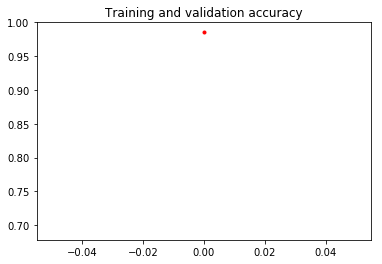

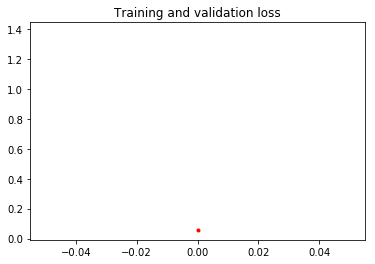

In [42]:
nb_train_samples = 2250
nb_val_samples = 250
nb_epoch = 1
batch_size = 16
img_height, img_width =  256, 256
nb_classes = 50
train_data_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/Task5/train'
test_data_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/Task5/test'
train_gt = read_csv(join(train_data_dir, 'gt.csv'))
test_gt = read_csv(join(validation_data_dir, 'gt.csv'))


# setup model
base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
print("Model loaded.")

model = add_new_last_layer(base_model, nb_classes)

# transfer learning
setup_to_transfer_learn(model, base_model)

history_tl = model.fit_generator(
yagenerator(train_data_dir, train_gt, batch_size=batch_size),
nb_epoch=nb_epoch,
steps_per_epoch=nb_train_samples//batch_size,
validation_data=yagenerator(test_data_dir, test_gt, batch_size=batch_size),
validation_steps=nb_val_samples,
class_weight='auto')

# fine-tuning
setup_to_finetune(model)

history_ft = model.fit_generator(
yagenerator(train_data_dir, train_gt, batch_size=batch_size),
steps_per_epoch=nb_train_samples//batch_size,
nb_epoch=nb_epoch,
validation_data=yagenerator(test_data_dir, test_gt, batch_size=batch_size),
validation_steps=nb_val_samples,
class_weight='auto',
verbose=1)

model.save("model.hdf5")

plot_training(history_ft)